# Zernike Polynomial Evaluation

This notebook compares different methods for evaluating the radial part of the Zernike polynomials, in terms of both speed and accuracy

The two primary methods we consider are direct polynomial evaluation using Horner's method and an evaluation scheme based on a recurrence relation for Jacobi polynomials.

The radial part of the Zernike polynomials is given by

$$
    \mathcal{R}_l^{|m|} (\rho) = \sum_{s=0}^{(l-|m|)/2} \frac{(-1)^s(l-s)!}{ s!\left( \cfrac{l+|m|}{2} - s\right)! \left( \cfrac{l-|m|}{2} - s\right)!  } \rho^{l-2s}
$$

Because the coefficient of rho is made up of entirely integer operations, it can be evaluated quickly and exactly to arbitrary orders (recall that python natively supports arbitrary length integer arithmetic). These coefficients can then be evaluated using Horner's method. This is done in the `zernike_radial_poly` function.

The other approach uses the fact that the above equation can be written as

$$
    \mathcal{R}_l^{m} (\rho) = (-1)^{(l-m)/2} \rho^m  P_{(l-m)/2}^{m, 0} (1 - 2 \rho^2)  \hspace{1cm}\text{for } m\geq0
$$
where $P_{n}^{\alpha, \beta}(\rho)$ is a Jacobi polynomial. This allows us to use stable recurrence relations for the Jacobi polynomials, as is done in the `zernike_radial` function.

The recurrence relationship for the Jacobi polynomials is,
$$
    2n(c-n)(c-2)P_{n}^{\alpha,\beta}(\rho) = (c-1)[c(c-2)\rho + (a-b)(c-2n)]P_{n-1}^{\alpha,\beta}(\rho) - 2(a-1)(b-1)cP_{n-2}^{\alpha,\beta}(\rho)
$$
where 
$$
    c = 2n + \alpha + \beta, \hspace{1cm} a = n +\alpha, \hspace{1cm} b = n + \beta
$$

For the derivatives of Zernike Radial part, we will also need derivatives of Jacobi polynomials, for which there exist another relation. 
$$
    \cfrac{d^k}{dx^k} P_n^{(\alpha, \beta)}(x) = \cfrac{\Gamma(\alpha + \beta + n + 1 + k)}{2^k\Gamma(\alpha + \beta + n + 1)} P_{n-k}^{(\alpha + k, \beta + k)}(x)
$$
This function relates the derivatives to normal Jacobi function, and we can use above recursion relation to calculate derivatives.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
import numpy as np
import mpmath
import matplotlib
import matplotlib.pyplot as plt
from desc.basis import (
    polyder_vec,
    ZernikePolynomial,
    zernike_radial,
    zernike_radial_coeffs,
    zernike_radial_poly,
)

DESC version 0.11.1+580.gf95104d87.dirty,using JAX backend, jax version=0.4.25, jaxlib version=0.4.25, dtype=float64
Using device: CPU, with 6.75 GB available memory


In [3]:
basis = ZernikePolynomial(L=50, M=50, spectral_indexing="ansi", sym="cos")
r = np.linspace(0, 1, 100)

Here we time the evaluation for a basis set containing 676 modes on a grid of 100 points, for derivative orders 0 through 3. (note the `block_until_ready` is needed to get [accurate timing with jax](https://jax.readthedocs.io/en/latest/async_dispatch.html))

In [4]:
print("zernike_radial, 0th derivative")
%timeit _ = zernike_radial(r[:, np.newaxis], basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
print("zernike_radial, 1st derivative")
%timeit _ = zernike_radial(r[:, np.newaxis], basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
print("zernike_radial, 2nd derivative")
%timeit _ = zernike_radial(r[:, np.newaxis], basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
print("zernike_radial, 3rd derivative")
%timeit _ = zernike_radial(r[:, np.newaxis], basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()

zernike_radial, 0th derivative
5.35 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
zernike_radial, 1st derivative
10.2 ms ± 958 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
zernike_radial, 2nd derivative
12.6 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
zernike_radial, 3rd derivative
17.3 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
print("zernike_radial_poly, 0th derivative")
%timeit _ = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=0, exact=False)
print("zernike_radial_poly, 1st derivative")
%timeit _ = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=1, exact=False)
print("zernike_radial_poly, 2nd derivative")
%timeit _ = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=2, exact=False)
print("zernike_radial_poly, 3rd derivative")
%timeit _ = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=3, exact=False)

zernike_radial_poly, 0th derivative
17.2 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
zernike_radial_poly, 1st derivative
25.2 ms ± 5.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
zernike_radial_poly, 2nd derivative
29.8 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
zernike_radial_poly, 3rd derivative
27.3 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that the implementation using Jacobi polynomial recurrence relation is significantly faster, despite the overhead from the JAX just-in-time compiler

For accuracy comparison, we will also evaluate the Zernike radial polynomials in extended precision (100 digits of accuracy) and treat this as the "true" value.

In [6]:
mpmath.mp.dps = 100
print("Calculate radial Zernike polynomial coefficients (exact)")
%time c = zernike_radial_coeffs(basis.modes[:, 0], basis.modes[:, 1], exact=True)

print("\nzernike_radial_exact, 0th derivative")
%time zt0 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in c]).T
print("zernike_radial_exact, 1st derivative")
%time zt1 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 1, exact=True)]).T
print("zernike_radial_exact, 2nd derivative")
%time zt2 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 2, exact=True)]).T
print("zernike_radial_exact, 3rd derivative")
%time zt3 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 3, exact=True)]).T

Calculate radial Zernike polynomial coefficients (exact)
CPU times: user 23.5 ms, sys: 0 ns, total: 23.5 ms
Wall time: 22.7 ms

zernike_radial_exact, 0th derivative
CPU times: user 9.65 s, sys: 73.7 ms, total: 9.73 s
Wall time: 9.74 s
zernike_radial_exact, 1st derivative
CPU times: user 9.23 s, sys: 32.4 ms, total: 9.26 s
Wall time: 9.29 s
zernike_radial_exact, 2nd derivative
CPU times: user 9.18 s, sys: 61.6 ms, total: 9.25 s
Wall time: 9.26 s
zernike_radial_exact, 3rd derivative
CPU times: user 9.43 s, sys: 131 ms, total: 9.56 s
Wall time: 9.6 s


Next we can plot the error resulting from the two evaluation methods (polynomial evaluation and jacobi recurrence relation) vs the true solution computed in exact arithmetic. We plot the max absolute error as well as the max relative error over $\rho \in (0,1)$ for each derivative order.

In [7]:
zr0 = zernike_radial(r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 0)
zr1 = zernike_radial(r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 1)
zr2 = zernike_radial(r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 2)
zr3 = zernike_radial(r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 3)
zp0 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=0, exact=False
)
zp1 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=1, exact=False
)
zp2 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=2, exact=False
)
zp3 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=3, exact=False
)

In [ ]:
def plot_comparison(exact, methods, basis, dx=0, type="absolute"):
    """Plot comparison of exact and approximate methods."""

    assert type in ["absolute", "relative"], "type must be 'absolute' or 'relative'"

    N = len(methods)
    res = basis.L

    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "Custom cmap", cmaplist, cmap.N
    )

    # define the bins and normalize
    bounds = np.logspace(-16, 0, 17)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1, N, squeeze=True, figsize=(N * 5, 4))
    for i in range(N):
        algo = "Poly" if i == 0 else "Jacobi"
        if dx == 0:
            Zmn = "Z_{lm}(x)"
            Zmn_p = "\\tilde{Z}_{lm}(x)"
        else:
            derv = "^" + str(dx) if dx > 1 else ""
            Zmn = "\\frac{d" + derv + "Z_{lm}(x)}{d x" + derv + "}"
            Zmn_p = "\\frac{d" + derv + "\\tilde{Z}_{lm}(x)}{d x" + derv + "}"
        if type == "absolute":
            c = np.max(abs(methods[i] - exact), axis=0)
            title = (
                f"{algo}:" + "$\\max_{x \\in (0,1)} |" + Zmn + "-" + Zmn_p + "|$"
            )
        else:
            c = np.max(abs(methods[i] - exact), axis=0) / np.mean(abs(exact))
            derv = "'"*dx if dx >= 1 else ""
            title = (
                f"{algo}:"
                + "$\\max_{x \\in (0,1)} |"
                + Zmn
                + "-"
                + Zmn_p
                + "| / |\\bar{Z}"
                + derv   
                + "_{lm}|$"
            )
        im = ax[i].scatter(
            basis.modes[:, 0],
            basis.modes[:, 1],
            c=c,
            norm=norm,
            cmap=cmap,
        )

        ax[i].grid(True)
        ax[i].set_xticks(np.arange(0, res + 1, 5))
        ax[i].set_yticks(np.arange(0, res + 1, 5))
        ax[i].set_xlabel("$l$", fontsize=12)
        ax[i].set_ylabel("$m$", fontsize=12)
        ax[i].set_title(title, fontsize=14)
    # Create a separate axis for the colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=bounds)
    cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])

## Absolute Error

### 0th derivative

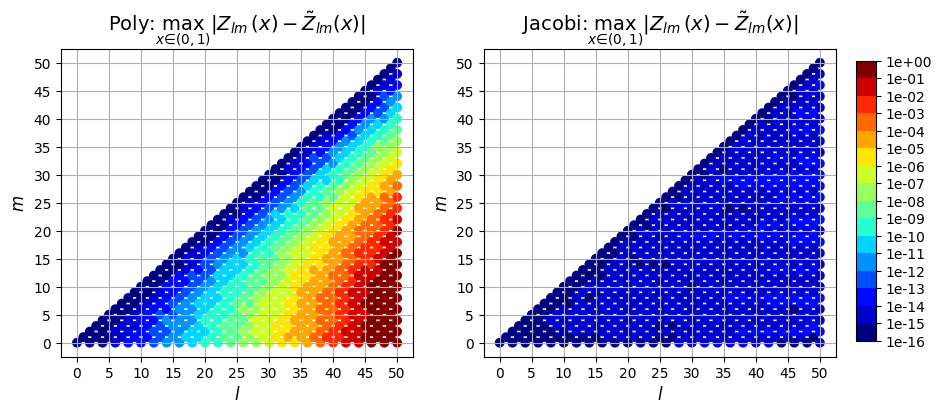

In [ ]:
plot_comparison(zt0, (zp0, zr0), basis, 0, "absolute")

### 1st derivative

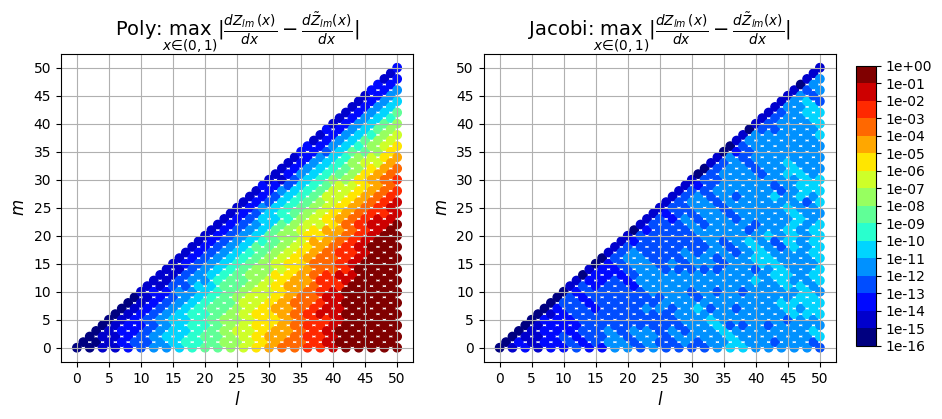

In [ ]:
plot_comparison(zt1, (zp1, zr1), basis, 1, "absolute")

### 2nd derivative

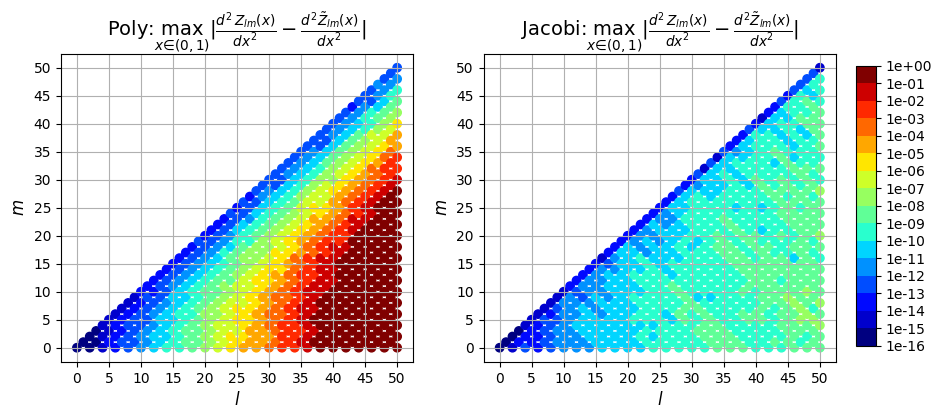

In [ ]:
plot_comparison(zt2, (zp2, zr2), basis, 2, "absolute")

### 3rd derivative

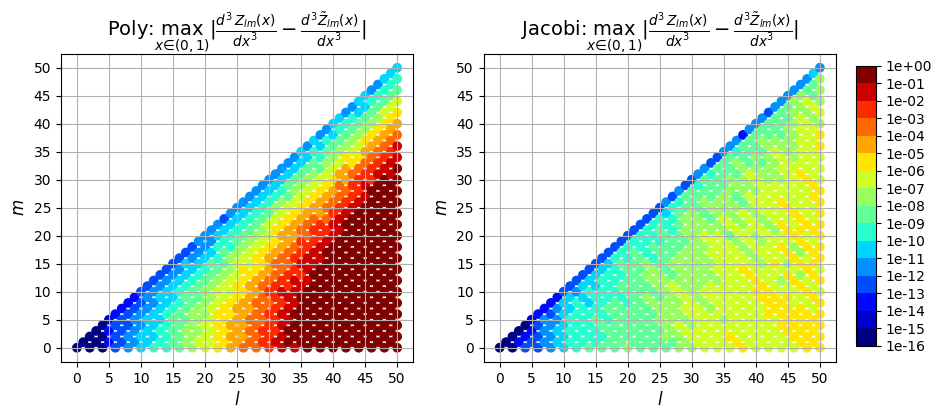

In [ ]:
plot_comparison(zt3, (zp3, zr3), basis, 3, "absolute")

## Relative Error

### 0th derivative

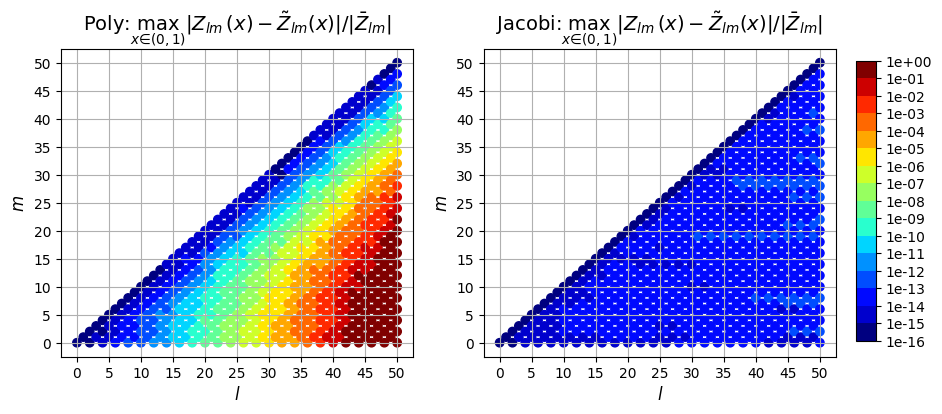

In [ ]:
plot_comparison(zt0, (zp0, zr0), basis, 0, "relative")

### 1st derivative

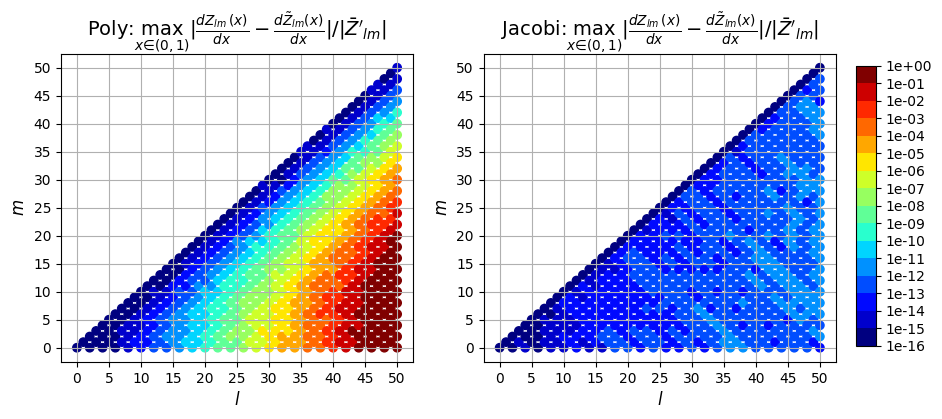

In [ ]:
plot_comparison(zt1, (zp1, zr1), basis, 1, "relative")

### 2nd derivative

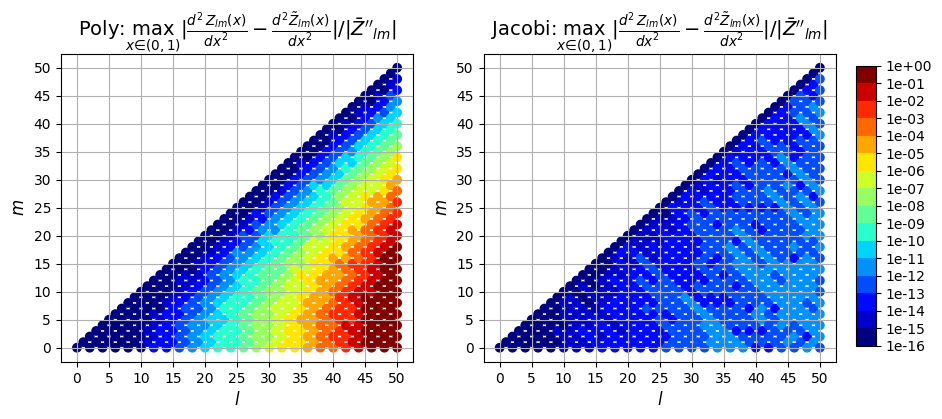

In [ ]:
plot_comparison(zt2, (zp2, zr2), basis, 2, "relative")

### 3rd derivative

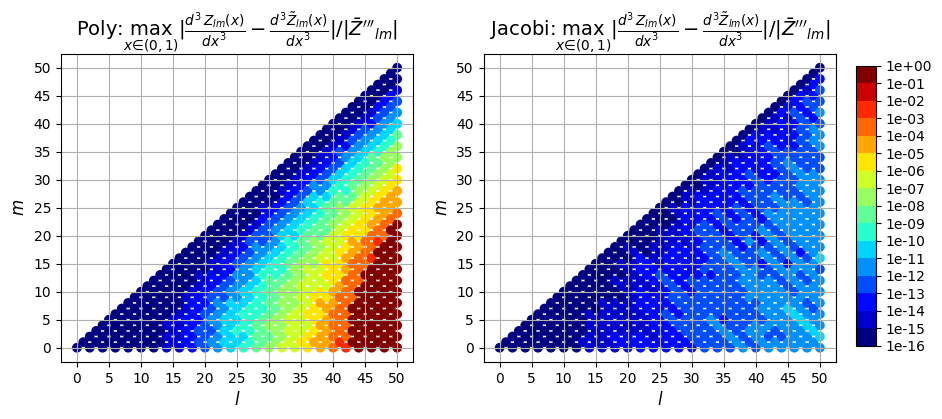

In [ ]:
plot_comparison(zt3, (zp3, zr3), basis, 3, "relative")

So in addition to being faster, the evaluation using the Jacobi recurrence relation is also significantly more accurate as the mode numbers increase, keeping absolute error less than $10^{-5}$ and relative error less than $10^{-9}$, while directly evaluating the polynomial leads to errors greater than 100\% for large $l$